In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import sys
import pandas as pd
import random
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
import numpy as np
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.models import Model
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
x = np.load('/content/drive/MyDrive/Datasets/fold1/images.npy')
y = np.load('/content/drive/MyDrive/Datasets/fold1/types.npy')


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20, random_state= 1)


In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


In [ ]:
#encoding y_train

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y_train = onehot_encoded

[ 3 17  5 ...  3  3 12]


In [ ]:
#encoding y_val

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_val)
#print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y_val = onehot_encoded

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state= 1)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1719, 256, 256, 3) (1719, 19)
(532, 256, 256, 3) (532, 19)
(192, 256, 256, 3) (192, 19)


**REsNet50 using for folder 1**

In [ ]:
#@title Default title text
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train)
val_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
val_generator.fit(x_val)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test)
#Initializing ResNet50
from tensorflow.keras.applications import ResNet50
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))
#model_resnet.summary()
from tensorflow.keras.optimizers import SGD
model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train ,y_train, epochs=1, validation_data =(x_val, y_val), verbose=1)
test_score = model_resnet.evaluate(x_test, y_test, verbose = 1) 
model_resnet.save('resNet50 epoch 25 fold1.h5')

**Vgg19 model**

In [ ]:
#@title Default title text

from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model

# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, batch_size = 128, epochs = 1, verbose = 1, validation_data = (x_val, y_val))

	# evaluate model
	acc = model.evaluate(x_test, y_test, verbose=1)
	
	model.save('vgg19 fold1 20 epoch x_train.h5')


run_test_harness()

**Vgg16 fold 1**

In [ ]:
#@title Default title text
# from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, epochs=1, verbose=1, validation_data = (x_val, y_val))
	# evaluate model
	acc = model.evaluate(x_test, y_test, verbose=1)
	
	# save model
	model.save('vgg16 fold1 20 epoch y_train.h5')


run_test_harness()

**DenseNet fold1**

In [ ]:
#@title Default title text
import tensorflow as tf
base_model_denseNet= tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=y_train.shape[1],
    
)
#Adding layers to the ResNet50
model_dense=Sequential()
#Add the Dense layers along with activation and batch normalization
model_dense.add(base_model_denseNet)
model_dense.add(Flatten())
#Add the Dense layers along with activation and batch normalization
# model_dense.add(Dense(1024,activation=('relu'), input_dim=512))
model_dense.add(Dense(512,activation=('relu'))) 
model_dense.add(Dropout(.4))
model_dense.add(Dense(256,activation=('relu'))) 
model_dense.add(Dropout(.3))
model_dense.add(Dense(128,activation=('relu')))
model_dense.add(Dropout(.2))
model_dense.add(Dense(19,activation=('softmax')))

from tensorflow.keras.optimizers import SGD
model_dense.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
dense_net_history = model_dense.fit(x_train, y_train, epochs=1, validation_data = (x_test, y_test), verbose=1)
score = model_dense.evaluate(x_test, y_test, verbose= 1)

In [8]:
#First Spliting the dataset into three parts
x_train1, x_train3, y_train1, y_train3 = train_test_split(x,y, test_size=.33, random_state=1)
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train1, y_train1, test_size=.50, random_state=1)

In [9]:
#Now printing the shape and size of three parts
print(x_train1.shape, y_train1.shape)
print(x_train2.shape, y_train2.shape)
print(x_train3.shape, y_train3.shape)

(889, 256, 256, 3) (889,)
(890, 256, 256, 3) (890,)
(877, 256, 256, 3) (877,)


In [11]:
#encoding y_train1

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train1)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y_train1 = onehot_encoded

In [12]:
#encoding y_train2

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train2)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y_train2 = onehot_encoded

In [13]:
#encoding y_train3

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train3)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y_train3 = onehot_encoded

In [14]:
#Now printing the shape and size of three parts
print(x_train1.shape, y_train1.shape)
print(x_train2.shape, y_train2.shape)
print(x_train3.shape, y_train3.shape)

(889, 256, 256, 3) (889, 19)
(890, 256, 256, 3) (890, 19)
(877, 256, 256, 3) (877, 19)


In [15]:
# spliting x_train1 and y_train1 into train , validation and test set
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=.2, random_state=1)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train1, y_train1, test_size=.1, random_state=1)
#printing the shape
print("................printing the sahpe..............")
print(x_train1.shape, y_train1.shape)
print(x_val1.shape, y_val1.shape)
print(x_test1.shape, y_test1.shape)

................printing the sahpe..............
(639, 256, 256, 3) (639, 19)
(178, 256, 256, 3) (178, 19)
(72, 256, 256, 3) (72, 19)


In [16]:
# spliting x_train2 and y_train2 into train , validation and test set
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=.2, random_state=1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train2, y_train2, test_size=.1, random_state=1)
#printing the shape
print("printing the sahpe..............")
print(x_train2.shape, y_train2.shape)
print(x_val2.shape, y_val2.shape)
print(x_test2.shape, y_test2.shape)

printing the sahpe..............
(640, 256, 256, 3) (640, 19)
(178, 256, 256, 3) (178, 19)
(72, 256, 256, 3) (72, 19)


In [17]:
# spliting x_train3 and y_train3 into train , validation and test set
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, y_train3, test_size=.2, random_state=1)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_train3, y_train3, test_size=.1, random_state=1)
#printing the shape
print("printing the sahpe..............")
print(x_train3.shape, y_train3.shape)
print(x_val3.shape, y_val3.shape)
print(x_test3.shape, y_test3.shape)

printing the sahpe..............
(630, 256, 256, 3) (630, 19)
(176, 256, 256, 3) (176, 19)
(71, 256, 256, 3) (71, 19)


**ResNet50 Model for ensembling, fold 1**

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
val_generator.fit(x_val1)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test1)


#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))

#Summary of ResNet50 Model
#model_resnet.summary()

model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train1 ,y_train1, epochs=1, validation_data =(x_val1, y_val1), verbose=1)
score = model_resnet.evaluate(x_test1, y_test1, verbose=1)
model_resnet.save('resNet50-epoch25-fold1.h5')

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                         

**VGG19 for ensembling fold 1**

In [19]:


from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model

# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train2, y_train2, batch_size = 128, epochs = 1, verbose = 1, validation_data = (x_val2, y_val2))

	# evaluate model
	acc = model.evaluate(x_test2, y_test2, verbose=1)
	
	model.save('vgg19 fold1 20 epoch x_train.h5')


run_test_harness()

80150528/80134624 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


3/3 [==============================] - 4s 999ms/step - loss: 8.3736 - accuracy: 0.2639


**Model VGG16 using for ensemble fold1**

In [20]:


from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train3, y_train3, epochs=1, verbose=1, validation_data = (x_val3, y_val3))
	# evaluate model
	acc = model.evaluate(x_test3, y_test3, verbose=1)
	
	# save model
	model.save('vgg16 fold1 20 epoch y_train.h5')


run_test_harness()

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


3/3 [==============================] - 3s 766ms/step - loss: 3.1417 - accuracy: 0.2535


In [ ]:
#@title Sequential model 1
# #Model 1

# #Defining the Convolutional Neural Network
# model1 = Sequential()

# model1.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(64, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(128, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Flatten())

# model1.add(Dense(128, activation = 'relu'))
# model1.add(Dense(19, activation = 'softmax'))


# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model1.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model1.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history1 = model1.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model1.save('model 1 fold1 epoch 10.hdf5')

In [ ]:
#@title sequential model 2
# model2 = Sequential()

# model2.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model2.add(Conv2D(32, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(128, (3, 3), activation='relu'))
# model2.add(Conv2D(25, (1,1)))

# model2.add(Flatten())

# model2.add(Dense(19, activation = 'softmax'))

# model2.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model2.summary()

# history2 = model2.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model2.save('model2 fold1 epoch 10.hdf5')

In [ ]:
#@title Sequential model 3

# model3 = Sequential()

# model3.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Conv2D(64, (3, 3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Flatten())

# model3.add(Dense(19, activation = 'softmax'))

# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model3.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model3.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history3 = model3.fit(x_train2, y_train2, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model3.save('model3 fold3 epoch 10.hdf5')


**Ensembling all the three models (VGG16, Vgg19, RestNet50)**


In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

In [22]:
model1 = load_model('resNet50-epoch25-fold1.h5')
model2 = load_model('vgg19 fold1 20 epoch x_train.h5')
model3 = load_model('vgg16 fold1 20 epoch y_train.h5')


In [23]:
models = [model1, model2, model3] 


In [24]:
preds = [model.predict(x_val1) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [25]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_val1)
prediction2 = model2.predict(x_val1)
prediction3 = model3.predict(x_val1)


In [29]:
accuracy1 = accuracy_score(np.argmax(y_val1, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_val1, axis=1), np.argmax(prediction2, axis= 1))
accuracy3 = accuracy_score(np.argmax(y_val1, axis=1), np.argmax(prediction3, axis= 1))


ensemble_accuracy = accuracy_score(np.argmax(y_val1, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.12359550561797752
Accuracy Score for model2 =  0.3089887640449438
Accuracy Score for model3 =  0.3089887640449438
Accuracy Score for average ensemble =  0.30337078651685395


In [32]:
#Weighted average ensemble
models = [model1, model2,model3] 
preds = [model.predict(x_val2) for model in models]
preds=np.array(preds)

weights = [.4, .3,.3] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_val2, axis= 1), weighted_ensemble_prediction)

In [33]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.12359550561797752
Accuracy Score for model2 =  0.3089887640449438
Accuracy Score for model3 =  0.3089887640449438
Accuracy Score for average ensemble =  0.30337078651685395
Accuracy Score for weighted average ensemble =  0.24719101123595505


In [37]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_val2) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_val2, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2], " and w3=", max_acc_row[3])         


Max accuracy of  0.1  obained with w1= 0.1  w2= 0.3  and w3= 34.831460674157306


In [38]:
class_names =['Adrenal', 'Bile duct', 'Bladder', 'Breast', 'Colon', 'Cervix', 'Esophagus', 'Head&Neck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Testis', 'Stomach', 'Thyroid', 'Uterus']

Predicted Label:  Cervix
True Label:  Cervix


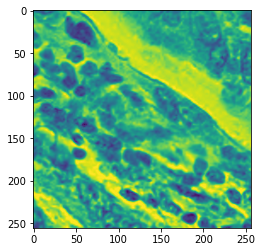

In [41]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model2, model3]
preds = [model.predict(x_val2) for model in models]
preds=np.array(preds)
ideal_weights = [.1, .4, .5] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_val2, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_val2[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_val2[i])])



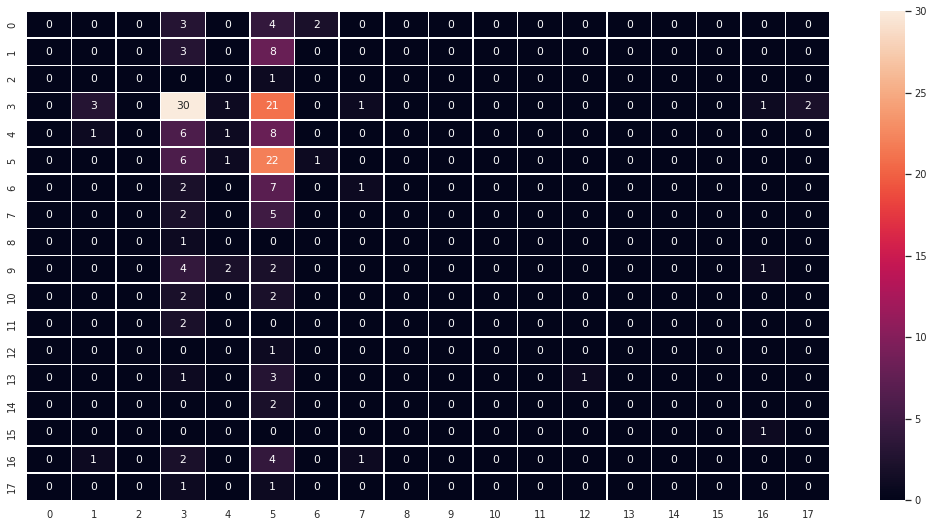

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_val2, axis=1 ), ideal_weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(18,9))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)